# Topic ----- Can we accurately predict the hourly ridership for any given station and hour using historical OD(Origin-Destination) data

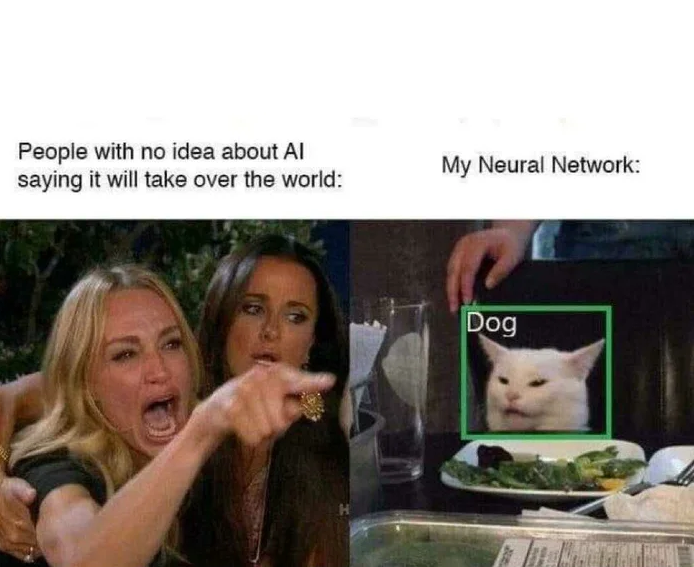

In [28]:
from IPython.display import Image
Image('img.png')


# **Data Preprocessing**

In [33]:
import pandas as pd
df = pd.read_csv("komuter_2025.csv")

# Convert to datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Drop unused columns
df.drop(['date', 'time'], axis=1, inplace=True)

# Check and drop missing values
print(df.isnull().sum())
df.dropna(inplace=True)

# Check datatypes and min/max
print(df.dtypes)
print(df['ridership'].min(), df['ridership'].max())

# Aggregate ridership by hour
hourly_df = df.groupby('datetime').agg(total_ridership=('ridership', 'sum')).reset_index()
hourly_df.set_index('datetime', inplace=True)
# Create time-related features for modeling
hourly_df['hour'] = hourly_df.index.hour
hourly_df['day_of_week'] = hourly_df.index.dayofweek
hourly_df['is_weekend'] = hourly_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

hourly_df.head()


origin         0
destination    0
ridership      0
datetime       0
dtype: int64
origin                 object
destination            object
ridership               int64
datetime       datetime64[ns]
dtype: object
1 712


,total_ridership,hour,day_of_week,is_weekend
datetime,,,,
2025-01-01 00:00:00,89,0,2,0
2025-01-01 01:00:00,26,1,2,0
2025-01-01 02:00:00,4,2,2,0
2025-01-01 03:00:00,6,3,2,0
2025-01-01 04:00:00,24,4,2,0


# **Feature Engineering**

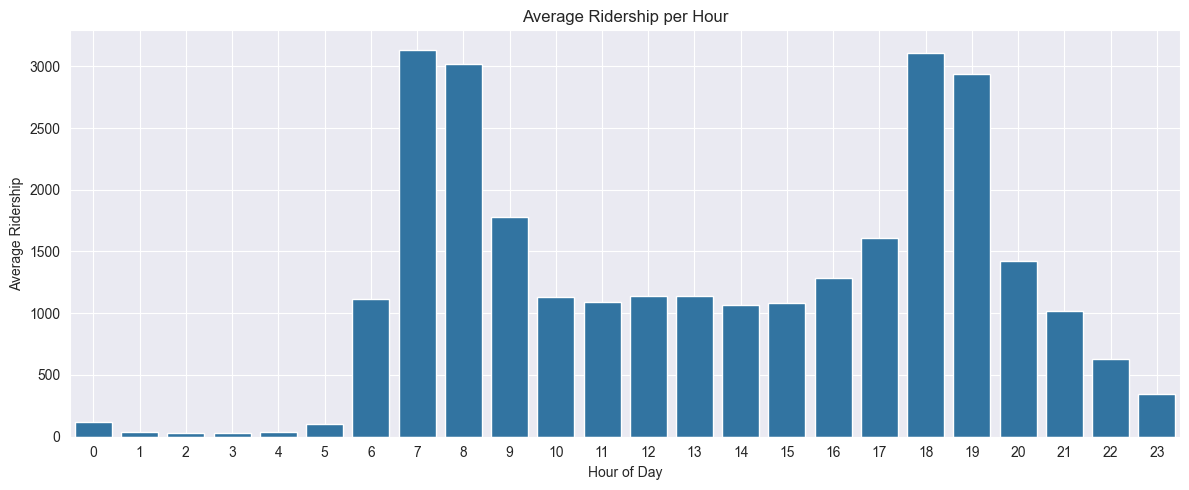

In [34]:
# Extract hour and day of week from datetime index
hourly_df['hour'] = hourly_df.index.hour
hourly_df['day_of_week'] = hourly_df.index.dayofweek

# Create a new column: is_weekend (1 for Saturday/Sunday, else 0)
hourly_df['is_weekend'] = hourly_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar chart showing average ridership by hour
plt.figure(figsize=(12, 5))
sns.barplot(data=hourly_df, x='hour', y='total_ridership', errorbar=None)

plt.title('Average Ridership per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Ridership')
plt.grid(True)
plt.tight_layout()
plt.show()


# **Train/Test Split**

In [35]:
from sklearn.model_selection import train_test_split
X = hourly_df[['hour', 'day_of_week', 'is_weekend']]
y = hourly_df['total_ridership']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("Size of train:", X_train.shape)
print("Size of test:", X_test.shape)


Size of train: (2619, 3)
Size of test: (655, 3)


# **Random Forest Model**

 Random Forest Evaluation Metrics:
 Mean Squared Error (MSE):  227770.48
 Root Mean Squared Error (RMSE): 477.25
 Mean Absolute Error (MAE):  255.07
 R² Score:   0.8291


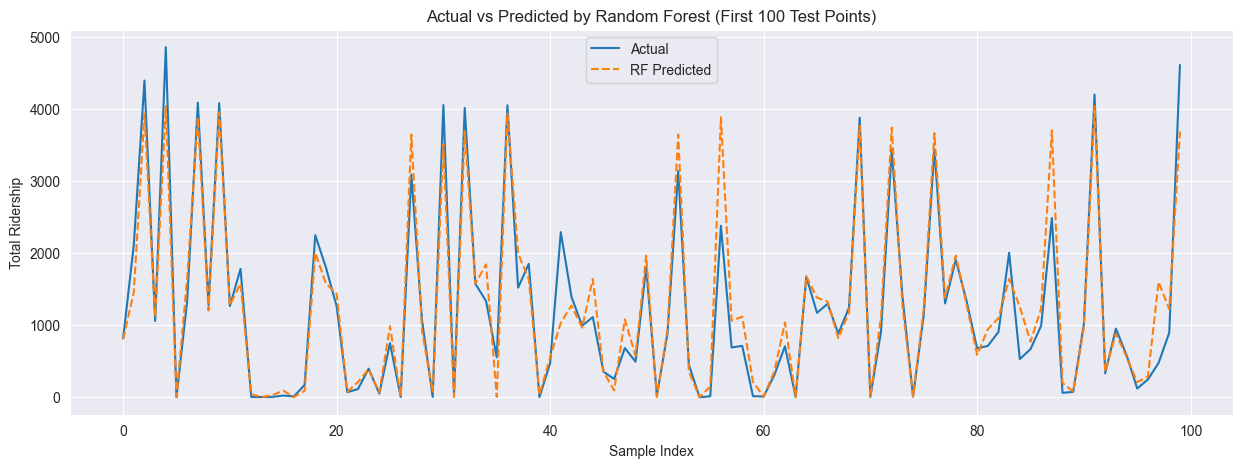

In [36]:
#  Import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

#  Initialize and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,     # Number of trees (higher = more stable but slower)
    max_depth=None,       # Maximum depth of trees (None = no limit)
    random_state=42       # For reproducibility
)
rf_model.fit(X_train, y_train)

#  Predict on the test set
y_pred_rf = rf_model.predict(X_test)

#  Evaluate the model
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(" Random Forest Evaluation Metrics:")
print(f" Mean Squared Error (MSE):  {mse:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f" Mean Absolute Error (MAE):  {mae:.2f}")
print(f" R² Score:   {r2:.4f}")  # Closer to 1 means better fit

#  Visualize the first 100 prediction results
plt.figure(figsize=(15,5))
plt.plot(range(100), y_test[:100], label="Actual")
plt.plot(range(100), y_pred_rf[:100], label="RF Predicted", linestyle='dashed')
plt.title("Actual vs Predicted by Random Forest (First 100 Test Points)")
plt.xlabel("Sample Index")
plt.ylabel("Total Ridership")
plt.legend()
plt.grid(True)
plt.show()

# **SVR Model**

SVR Evaluation:
Mean Squared Error (MSE):  1157977.89
Root Mean Squared Error (RMSE): 1076.09
Mean Absolute Error (MAE):  590.58
R² Score: 0.1309


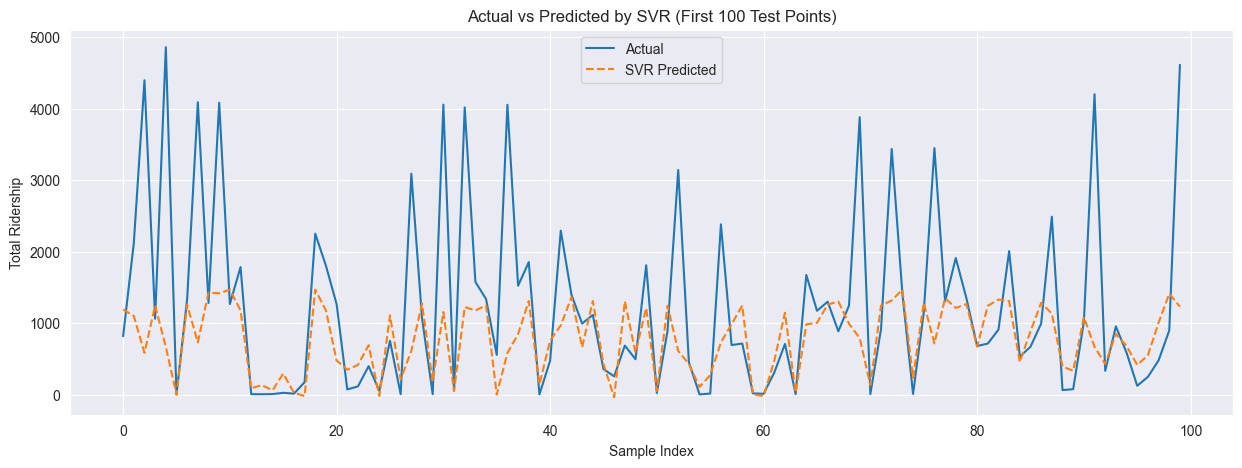

In [37]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Standardize the features (do not scale the target variable)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVR model (default kernel is 'rbf')
svr_model = SVR(kernel='rbf', C=100, epsilon=10)  # You may tune C and epsilon

# Train the model
svr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)

print("SVR Evaluation:")
print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE):  {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Safe plotting: auto match available data length
n = min(len(y_test), len(y_pred_svr), 100)

plt.figure(figsize=(15, 5))
plt.plot(range(n), y_test[:n], label="Actual")
plt.plot(range(n), y_pred_svr[:n], label="SVR Predicted", linestyle='dashed')
plt.title("Actual vs Predicted by SVR (First {} Test Points)".format(n))
plt.xlabel("Sample Index")
plt.ylabel("Total Ridership")
plt.legend()
plt.grid(True)
plt.show()



# **Linear Regression Model**

Size of training set: (2619, 3)
Size of test set: (655, 3)
Linear Regression Evaluation:
Mean Absolute Error (MAE):  812.15
Root Mean Squared Error (RMSE): 1090.75
Mean Squared Error (MSE):  1189725.61
R² Score: 0.1071


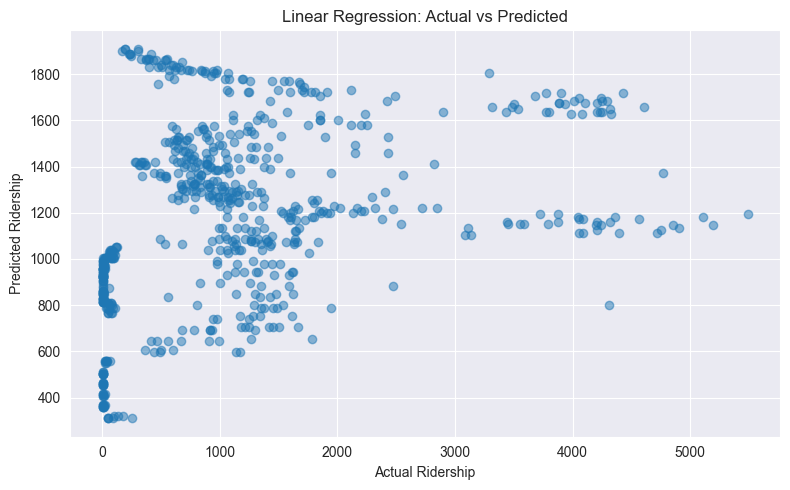

Regression Coefficients (Weights): [  47.74714211  -10.9138743  -435.22123561]
Intercept: 811.3232387435507


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- Feature and Target Selection ---
X = hourly_df[['hour', 'day_of_week', 'is_weekend']]
y = hourly_df['total_ridership']

# --- Train-Test Split (80% train, 20% test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Size of training set:", X_train.shape)
print("Size of test set:", X_test.shape)

# --- Initialize and Train Linear Regression Model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predict on Test Set ---
y_pred = model.predict(X_test)

# --- Evaluation Metrics ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Evaluation:")
print(f"Mean Absolute Error (MAE):  {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Visualize Predictions (Scatter Plot) ---
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Ridership")
plt.ylabel("Predicted Ridership")
plt.title("Linear Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Display Model Parameters ---
print("Regression Coefficients (Weights):", model.coef_)
print("Intercept:", model.intercept_)


# **Decision Tree**

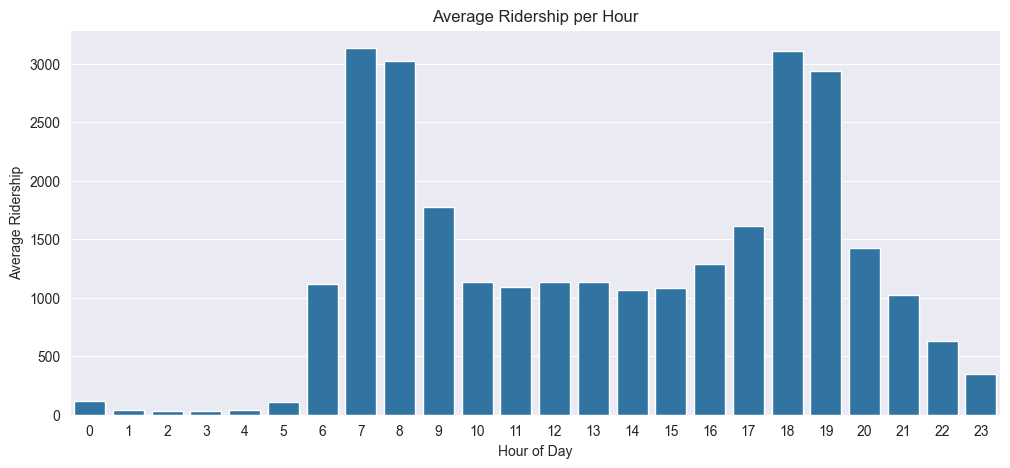

Decision Tree Evaluation:
Mean Absolute Error (MAE):  256.53
Root Mean Squared Error (RMSE): 478.09
Mean Squared Error (MSE):  228570.85
R² Score: 0.8285


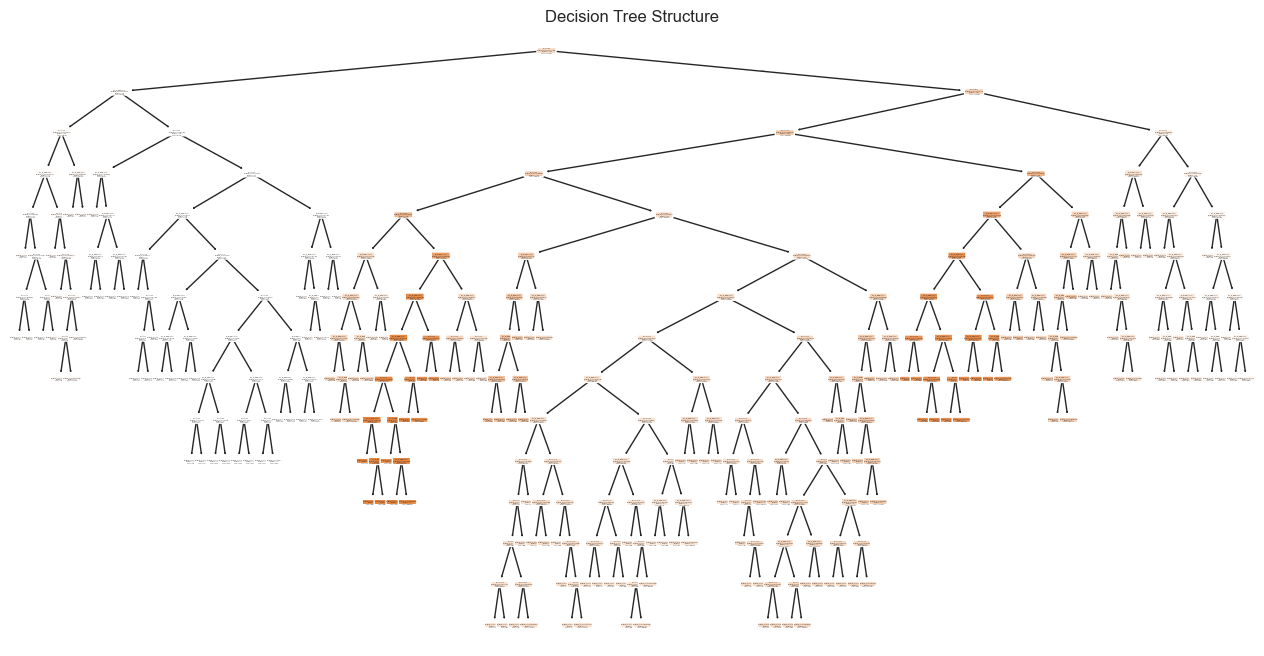

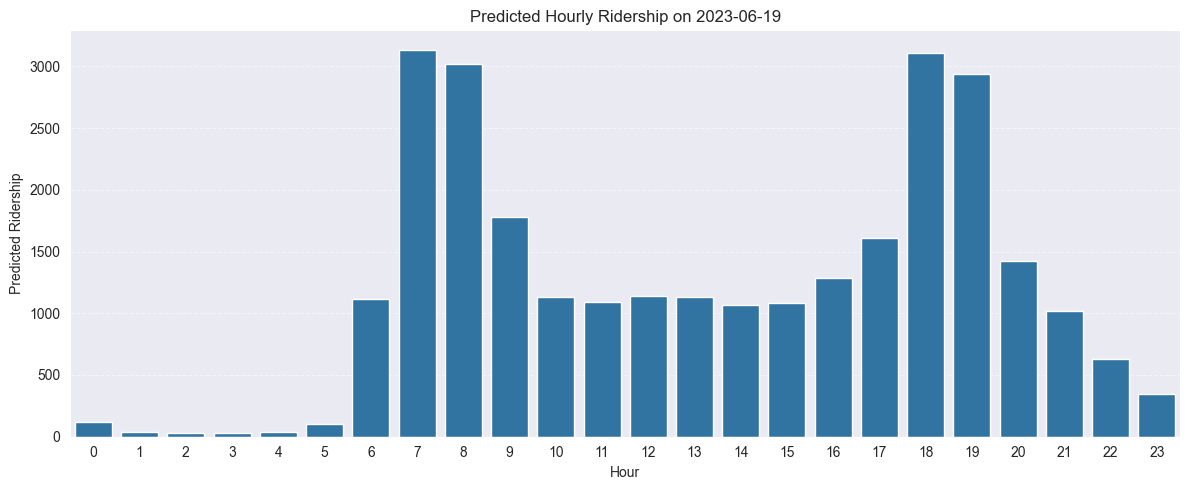

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- Feature Engineering ---
hourly_df['hour'] = hourly_df.index.hour
hourly_df['day_of_week'] = hourly_df.index.dayofweek
hourly_df['is_weekend'] = hourly_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# --- Visualize Average Ridership per Hour ---
plt.figure(figsize=(12, 5))
sns.barplot(data=hourly_df, x='hour', y='total_ridership', errorbar=None)
plt.title('Average Ridership per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Ridership')
plt.show()

# --- Modeling Setup ---
features = ['hour', 'day_of_week', 'is_weekend']
target = 'total_ridership'

X = hourly_df[features]
y = hourly_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Train Decision Tree Model ---
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# --- Predict and Evaluate ---
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Decision Tree Evaluation:")
print(f"Mean Absolute Error (MAE):  {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Visualize Decision Tree Structure ---
plt.figure(figsize=(16, 8))
plot_tree(model, feature_names=features, filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

# --- Predict 24-Hour Ridership for a Specific Date ---
date_str = '2023-06-19'
date = pd.to_datetime(date_str)
day_of_week = date.dayofweek
is_weekend = 1 if day_of_week >= 5 else 0

samples = pd.DataFrame({
    'hour': range(24),
    'day_of_week': [day_of_week] * 24,
    'is_weekend': [is_weekend] * 24
})

predicted = model.predict(samples)

# --- Visualize Daily Prediction as Bar Chart ---
plt.figure(figsize=(12, 5))
sns.barplot(data=hourly_df, x='hour', y='total_ridership', errorbar=None)
plt.title(f'Predicted Hourly Ridership on {date_str}')
plt.xlabel('Hour')
plt.ylabel('Predicted Ridership')
plt.xticks(range(24))
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# **XGBoost Model**

In [40]:
# Step 1: Feature Selection
X = hourly_df[['hour', 'day_of_week', 'is_weekend']]
y = hourly_df['total_ridership']

# Step 2: Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 3: Preprocessing Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scale numerical features
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['hour', 'day_of_week']),
], remainder='passthrough')  

# Step 4: XGBoost Training
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

xgb_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('xgb', XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42))
])

xgb_model.fit(X_train, y_train)

# Step 5: Prediction and Evaluation
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("XGBoost Evaluation:")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"MSE  (Mean Squared Error):       {mse:.2f}")
print(f"RMSE (Root Mean Squared Error):  {rmse:.2f}")
print(f"R²   (R-squared Score):          {r2:.3f}")

XGBoost Evaluation:
MAE  (Mean Absolute Error):      251.47
MSE  (Mean Squared Error):       215267.89
RMSE (Root Mean Squared Error):  463.97
R²   (R-squared Score):          0.838


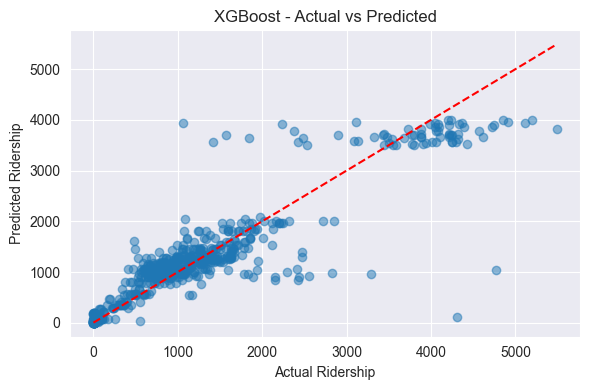

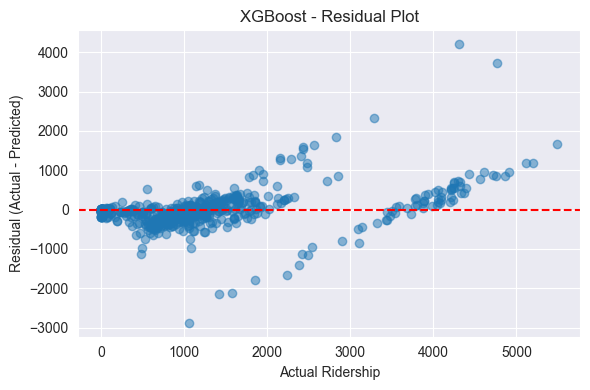

In [41]:
# Actual vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title("XGBoost - Actual vs Predicted")
plt.xlabel("Actual Ridership")
plt.ylabel("Predicted Ridership")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("XGBoost - Residual Plot")
plt.xlabel("Actual Ridership")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


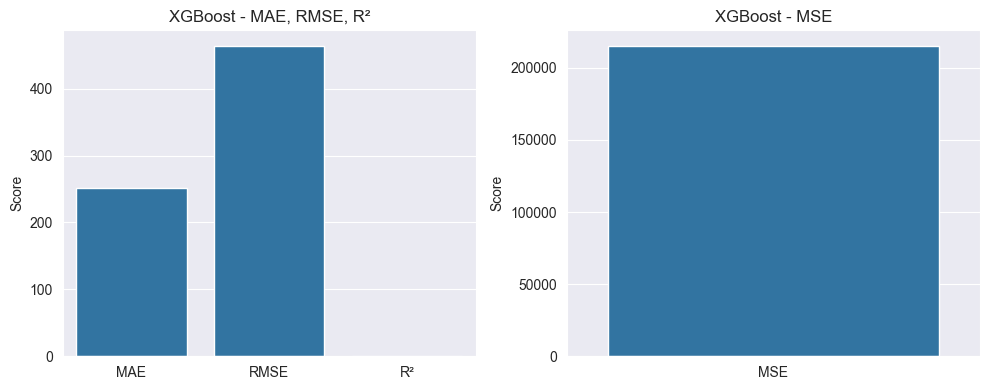

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


metrics_1 = {
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2
}

metrics_2 = {
    'MSE': mse
}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(x=list(metrics_1.keys()), y=list(metrics_1.values()), ax=axes[0])
axes[0].set_title("XGBoost - MAE, RMSE, R²")
axes[0].set_ylabel("Score")
axes[0].grid(True, axis='y')


sns.barplot(x=list(metrics_2.keys()), y=list(metrics_2.values()), ax=axes[1])
axes[1].set_title("XGBoost - MSE")
axes[1].set_ylabel("Score")
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()


## Quick Start for Regression

In [1]:
from auto_sklearn2 import AutoSklearnRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Load data
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the auto-sklearn regressor
auto_sklearn = AutoSklearnRegressor(time_limit=120, random_state=42)
auto_sklearn.fit(X_train, y_train)

# Make predictions
y_pred = auto_sklearn.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Best model: {auto_sklearn.best_params}")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Show all models performance
for model_name, score in auto_sklearn.get_models_performance().items():
    print(f"{model_name}: {score:.4f}")

Best model: {'preprocessor': 'standard_scaler', 'regressor': 'ridge'}
R² Score: 0.4541
Root Mean Squared Error: 53.7775
standard_scaler_random_forest: 0.3983
standard_scaler_gradient_boosting: 0.3652
standard_scaler_linear_regression: 0.4804
standard_scaler_ridge: 0.4808
standard_scaler_lasso: 0.4808
standard_scaler_elastic_net: 0.4584
standard_scaler_svr: 0.1003
standard_scaler_knn: 0.3447
standard_scaler_mlp: -0.2004
standard_scaler_decision_tree: -0.1240
standard_scaler_ada_boost: 0.3920
standard_scaler_extra_trees: 0.4290
standard_scaler_bagging: 0.3492
standard_scaler_sgd: 0.4776
standard_scaler_huber: 0.4730
standard_scaler_poisson: 0.4757
standard_scaler_gamma: 0.4263
standard_scaler_tweedie: 0.4292
standard_scaler_ransac: 0.1553
standard_scaler_linear_svr: 0.2380
standard_scaler_kernel_ridge: -3.5726
standard_scaler_pls: 0.4747
minmax_scaler_random_forest: 0.4018
minmax_scaler_gradient_boosting: 0.3686
minmax_scaler_linear_regression: 0.4804
minmax_scaler_ridge: 0.4800
minmax_s